<a href="https://colab.research.google.com/github/MissCrispenCakes/ml_labs/blob/patch-1/Lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5
---

In [ ]:
import keras
keras.__version__

'2.11.0'

In [ ]:
import gc

# Overfitting and underfitting

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


In all the examples we saw in the previous chapter -- movie review sentiment prediction, topic classification, and house price regression -- 
we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start 
degrading, i.e. our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning 
problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data.



---


At the **beginning of training, optimization and generalization are correlated**: the lower your loss on training data, the lower your loss on 
test data. While this is happening, **your model is said to be _under-fit_**: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data.

**After a certain number of iterations on the training data, generalization stops improving**: validation metrics stall then start degrading. **The model is starting to _over-fit_**: it is starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.



---



To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get 
more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization 
techniques, and let's apply them in practice to improve our movie classification model from  the previous chapter.

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

Let's prepare the data using the code from Chapter 3, Section 5:

In [ ]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000): #10000
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

17464789/17464789 [==============================] - 2s 0us/step


# Fighting overfitting

## Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets 
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [ ]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [ ]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 9s 85ms/step - loss: 0.4717 - acc: 0.8141 - val_loss: 0.3520 - val_acc: 0.8729
Epoch 2/20
49/49 [==============================] - 1s 31ms/step - loss: 0.2723 - acc: 0.9036 - val_loss: 0.2866 - val_acc: 0.8877
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.2114 - acc: 0.9238 - val_loss: 0.2805 - val_acc: 0.8880
Epoch 4/20
49/49 [==============================] - 1s 25ms/step - loss: 0.1789 - acc: 0.9378 - val_loss: 0.2887 - val_acc: 0.8854
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.1584 - acc: 0.9439 - val_loss: 0.3065 - val_acc: 0.8808
Epoch 6/20
49/49 [==============================] - 1s 26ms/step - loss: 0.1392 - acc: 0.9520 - val_loss: 0.3255 - val_acc: 0.8766
Epoch 7/20
49/49 [==============================] - 2s 32ms/step - loss: 0.1256 - acc: 0.9579 - val_loss: 0.3365 - val_acc: 0.8756
Epoch 8/20
49/49 [==============================] - 1s 28ms/step - loss: 0.1110 - a

In [ ]:
gc.collect()

1538

In [ ]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 3s 66ms/step - loss: 0.1870 - acc: 0.9808 - val_loss: 0.5853 - val_acc: 0.8618
Epoch 2/20
49/49 [==============================] - 1s 26ms/step - loss: 0.1803 - acc: 0.9809 - val_loss: 0.5704 - val_acc: 0.8603
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.1737 - acc: 0.9815 - val_loss: 0.5957 - val_acc: 0.8594
Epoch 4/20
49/49 [==============================] - 1s 30ms/step - loss: 0.1673 - acc: 0.9818 - val_loss: 0.5880 - val_acc: 0.8581
Epoch 5/20
49/49 [==============================] - 1s 24ms/step - loss: 0.1613 - acc: 0.9824 - val_loss: 0.6106 - val_acc: 0.8582
Epoch 6/20
49/49 [==============================] - 1s 26ms/step - loss: 0.1551 - acc: 0.9828 - val_loss: 0.6400 - val_acc: 0.8576
Epoch 7/20
49/49 [==============================] - 1s 25ms/step - loss: 0.1500 - acc: 0.9828 - val_loss: 0.6085 - val_acc: 0.8573
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.1445 - a

KeyboardInterrupt: ignored

In [ ]:
gc.collect()

774

In [ ]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

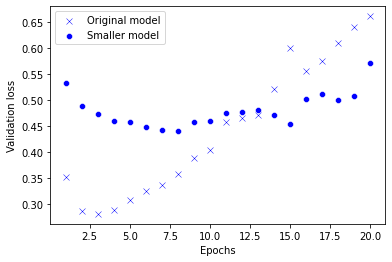

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def modelplot_Small():
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=smaller_model_val_loss, color="b", marker='o', label='Smaller model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_Small()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [ ]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 73ms/step - loss: 0.4895 - acc: 0.7786 - val_loss: 0.2993 - val_acc: 0.8787
Epoch 2/20
49/49 [==============================] - 1s 30ms/step - loss: 0.2747 - acc: 0.8869 - val_loss: 0.2709 - val_acc: 0.8874
Epoch 3/20
49/49 [==============================] - 1s 29ms/step - loss: 0.2181 - acc: 0.9140 - val_loss: 0.2750 - val_acc: 0.8861
Epoch 4/20
49/49 [==============================] - 1s 30ms/step - loss: 0.1641 - acc: 0.9358 - val_loss: 0.2864 - val_acc: 0.8825
Epoch 5/20
49/49 [==============================] - 1s 30ms/step - loss: 0.1208 - acc: 0.9550 - val_loss: 0.3507 - val_acc: 0.8701
Epoch 6/20
49/49 [==============================] - 2s 47ms/step - loss: 0.1003 - acc: 0.9655 - val_loss: 0.3251 - val_acc: 0.8819
Epoch 7/20
49/49 [==============================] - 1s 31ms/step - loss: 0.0622 - acc: 0.9788 - val_loss: 0.3626 - val_acc: 0.8805
Epoch 8/20
49/49 [==============================] - 1s 30ms/step - loss: 0.0517 - a

In [ ]:
gc.collect()

5176

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

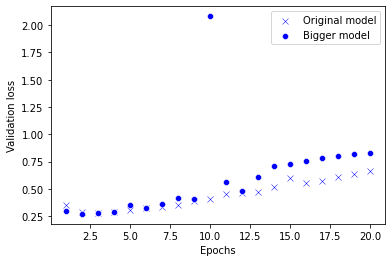

In [ ]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

def modelplot_Big():
  # f, ax = plt.subplots(figsize=(8,6))
  # sns.despine()
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=bigger_model_val_loss, color="b", marker='o', label='Bigger model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_Big()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

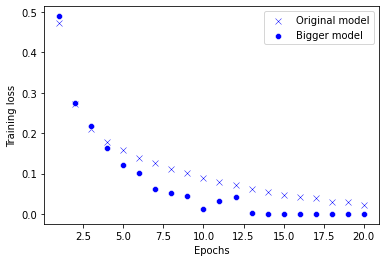

In [ ]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']
smaller_model_train_loss = smaller_model_hist.history['loss']

def modelplot_Train():
  sns.scatterplot(x=epochs, y=original_train_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=bigger_model_train_loss, color="b", marker='o', label='Bigger model')
  plt.xlabel('Epochs')
  plt.ylabel('Training loss')
  plt.legend()

modelplot_Train()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization

You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight 
regularization to our movie review classification network:

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2 regularization penalty:

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 72ms/step - loss: 0.6362 - acc: 0.6613 - val_loss: 0.5583 - val_acc: 0.7892
Epoch 2/20
49/49 [==============================] - 2s 31ms/step - loss: 0.4671 - acc: 0.8658 - val_loss: 0.4175 - val_acc: 0.8588
Epoch 3/20
49/49 [==============================] - 1s 25ms/step - loss: 0.3318 - acc: 0.9075 - val_loss: 0.3472 - val_acc: 0.8869
Epoch 4/20
49/49 [==============================] - 1s 25ms/step - loss: 0.2779 - acc: 0.9214 - val_loss: 0.3318 - val_acc: 0.8892
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.2538 - acc: 0.9297 - val_loss: 0.3505 - val_acc: 0.8790
Epoch 6/20
49/49 [==============================] - 1s 24ms/step - loss: 0.2404 - acc: 0.9348 - val_loss: 0.3430 - val_acc: 0.8832
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.2295 - acc: 0.9377 - val_loss: 0.3454 - val_acc: 0.8830
Epoch 8/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2195 - a

In [ ]:
gc.collect()

8664

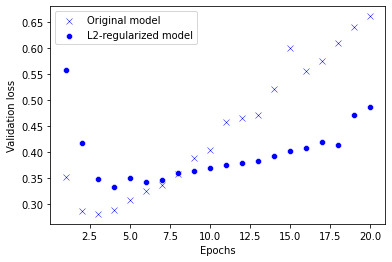

In [ ]:
l2_model_val_loss = l2_model_hist.history['val_loss']

def modelplot_L2():
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=l2_model_val_loss, color="b", marker='o', label='L2-regularized model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_L2()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), 
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [ ]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

In [ ]:
l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l1_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [ ]:
l1_model_hist = l1_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 74ms/step - loss: 0.9668 - acc: 0.7764 - val_loss: 0.6702 - val_acc: 0.8378
Epoch 2/20
49/49 [==============================] - 1s 27ms/step - loss: 0.6294 - acc: 0.8472 - val_loss: 0.5985 - val_acc: 0.8561
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5821 - acc: 0.8555 - val_loss: 0.5857 - val_acc: 0.8482
Epoch 4/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5570 - acc: 0.8610 - val_loss: 0.5568 - val_acc: 0.8599
Epoch 5/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5382 - acc: 0.8667 - val_loss: 0.5527 - val_acc: 0.8578
Epoch 6/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5251 - acc: 0.8706 - val_loss: 0.5193 - val_acc: 0.8699
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5118 - acc: 0.8724 - val_loss: 0.5644 - val_acc: 0.8436
Epoch 8/20
49/49 [==============================] - 2s 43ms/step - loss: 0.5036 - a

In [ ]:
gc.collect()

5177

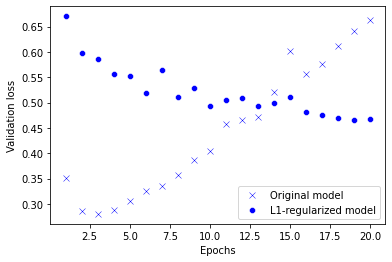

In [ ]:
l1_model_val_loss = l1_model_hist.history['val_loss']

def modelplot_L1():
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=l1_model_val_loss, color="b", marker='o', label='L1-regularized model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_L1()

In [ ]:
l12_model = models.Sequential()
l12_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                          activation='relu', input_shape=(10000,)))
l12_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                          activation='relu'))
l12_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l12_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [ ]:
l12_model_hist = l12_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 94ms/step - loss: 0.9818 - acc: 0.7747 - val_loss: 0.6743 - val_acc: 0.8504
Epoch 2/20
49/49 [==============================] - 1s 26ms/step - loss: 0.6395 - acc: 0.8485 - val_loss: 0.6339 - val_acc: 0.8393
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5927 - acc: 0.8572 - val_loss: 0.5747 - val_acc: 0.8629
Epoch 4/20
49/49 [==============================] - 2s 44ms/step - loss: 0.5710 - acc: 0.8589 - val_loss: 0.5867 - val_acc: 0.8476
Epoch 5/20
49/49 [==============================] - 2s 38ms/step - loss: 0.5503 - acc: 0.8672 - val_loss: 0.5801 - val_acc: 0.8465
Epoch 6/20
49/49 [==============================] - 2s 47ms/step - loss: 0.5417 - acc: 0.8642 - val_loss: 0.5477 - val_acc: 0.8633
Epoch 7/20
49/49 [==============================] - 2s 41ms/step - loss: 0.5347 - acc: 0.8665 - val_loss: 0.5316 - val_acc: 0.8665
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5292 - a

In [ ]:
gc.collect()

5178

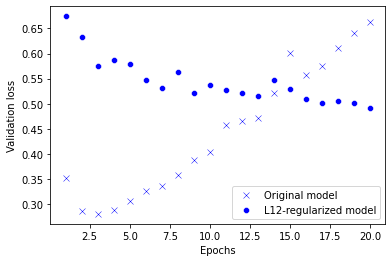

In [ ]:
l12_model_val_loss = l12_model_hist.history['val_loss']

def modelplot_L12():
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=l12_model_val_loss, color="b", marker='o', label='L12-regularized model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_L12()

## Adding dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be 
zero-ing out at random a fraction of the values in the matrix:

In [ ]:
## CODE SNIPPET
## At training time: we drop out 50% of the units in the output
#
# layer_output *= np.randint(0, high=2, size=layer_output.shape)
#


At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the 
units):

In [ ]:
## CODE SNIPPET
## At test time:
#
# layer_output *= 0.5
#


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is 
often the way it is implemented in practice:

In [ ]:
## CODE SNIPPET
## At training time:
#
# layer_output *= np.randint(0, high=2, size=layer_output.shape)
#
## Note that we are scaling *up* rather scaling *down* in this case
#
# layer_output /= 0.5
#


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
## CODE SNIPPET
#
# model.add(layers.Dropout(0.5))
#

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [ ]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 69ms/step - loss: 0.6045 - acc: 0.6666 - val_loss: 0.4711 - val_acc: 0.8573
Epoch 2/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4726 - acc: 0.7902 - val_loss: 0.3634 - val_acc: 0.8751
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3849 - acc: 0.8463 - val_loss: 0.3040 - val_acc: 0.8850
Epoch 4/20
49/49 [==============================] - 1s 25ms/step - loss: 0.3276 - acc: 0.8805 - val_loss: 0.2863 - val_acc: 0.8845
Epoch 5/20
49/49 [==============================] - 1s 27ms/step - loss: 0.2816 - acc: 0.8986 - val_loss: 0.2767 - val_acc: 0.8899
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.2464 - acc: 0.9131 - val_loss: 0.2815 - val_acc: 0.8891
Epoch 7/20
49/49 [==============================] - 2s 31ms/step - loss: 0.2238 - acc: 0.9239 - val_loss: 0.2971 - val_acc: 0.8891
Epoch 8/20
49/49 [==============================] - 1s 29ms/step - loss: 0.1987 - a

In [ ]:
gc.collect()

5178

Let's plot the results:

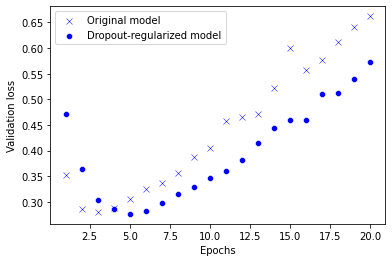

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

def modelplot_Drop():
  sns.scatterplot(x=epochs, y=original_val_loss, color="b", marker='x', label='Original model')
  sns.scatterplot(x=epochs, y=dpt_model_val_loss, color="b", marker='o', label='Dropout-regularized model')
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.legend()

modelplot_Drop()

# Conclusions


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout


Finally, let's take a look at all our results to see how the models compare. Notice the patterns of loss among the different models with under and over fitting constraints. 

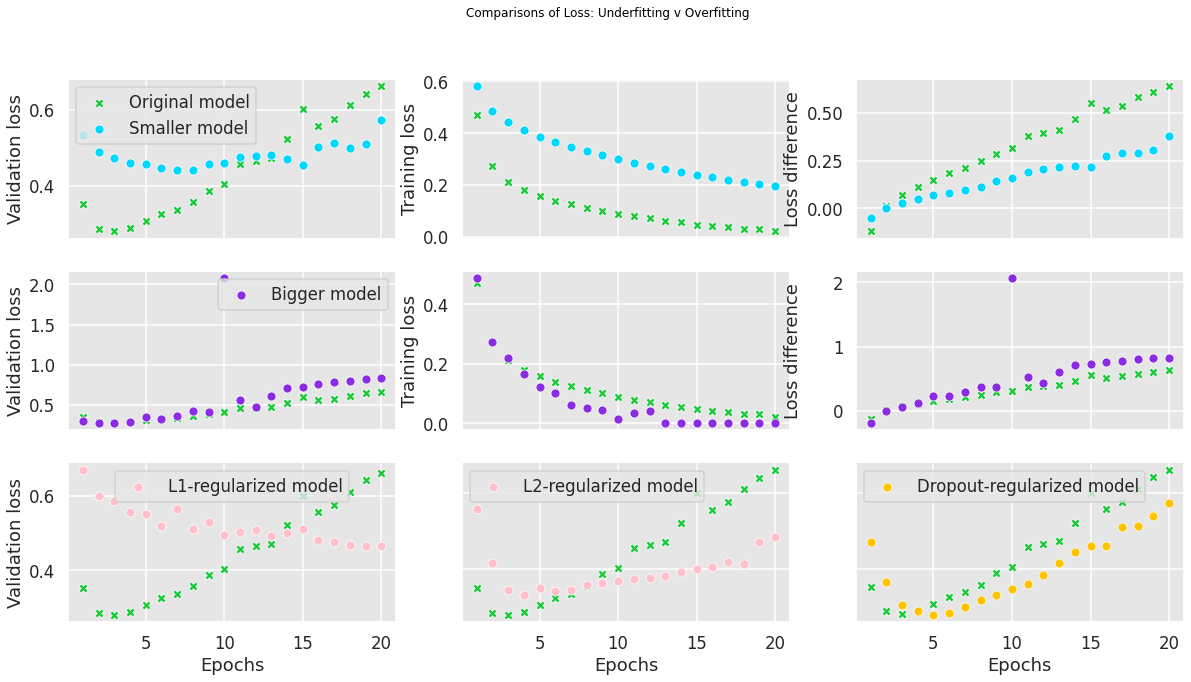

In [ ]:
# Layout all plots into one figure for easy comparison

f = plt.figure(figsize=(20, 10))
gs = f.add_gridspec(3, 3)

f.suptitle('Comparisons of Loss: Underfitting v Overfitting')

sns.set_palette("flare", n_colors=8, color_codes=True)
sns.set_color_codes(palette='bright')

original_diff = np.subtract(original_val_loss, original_train_loss)
smaller_diff = np.subtract(smaller_model_val_loss, smaller_model_train_loss)
bigger_diff = np.subtract(bigger_model_val_loss, bigger_model_train_loss)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax1 = f.add_subplot(gs[0, 0])
    sns.scatterplot(x=epochs, y=original_val_loss, color="g", marker='X', label='Original model')
    sns.scatterplot(x=epochs, y=smaller_model_val_loss, color="c", marker='o', label='Smaller model')
    plt.setp(ax1.get_xticklabels(), visible=False)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax2 = f.add_subplot(gs[0, 1])
    sns.scatterplot(x=epochs, y=original_train_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=smaller_model_train_loss, color="c", marker='o')
    plt.setp(ax2.get_xticklabels(), visible=False)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax3 = f.add_subplot(gs[0, 2])
    sns.scatterplot(x=epochs, y=original_diff, color="g", marker='X')
    sns.scatterplot(x=epochs, y=smaller_diff, color="c", marker='o')
    plt.setp(ax3.get_xticklabels(), visible=False)  

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax4 = f.add_subplot(gs[1, 0])
    sns.scatterplot(x=epochs, y=original_val_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=bigger_model_val_loss, color="m", marker='o', label='Bigger model')
    plt.setp(ax4.get_xticklabels(), visible=False)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax5 = f.add_subplot(gs[1, 1])
    sns.scatterplot(x=epochs, y=original_train_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=bigger_model_train_loss, color="m", marker='o')
    plt.setp(ax5.get_xticklabels(), visible=False)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax6 = f.add_subplot(gs[1, 2])
    sns.scatterplot(x=epochs, y=original_diff, color="g", marker='X')
    sns.scatterplot(x=epochs, y=bigger_diff, color="m", marker='o')
    plt.setp(ax6.get_xticklabels(), visible=False)

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax7 = f.add_subplot(gs[2, 0])
    sns.scatterplot(x=epochs, y=original_val_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=l1_model_val_loss, color="pink", marker='o', label='L1-regularized model')

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax8 = f.add_subplot(gs[2, 1])
    sns.scatterplot(x=epochs, y=original_val_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=l2_model_val_loss, color="pink", marker='o', label='L2-regularized model')
    plt.setp(ax8.get_yticklabels(), visible=False)  

with sns.axes_style("darkgrid", {"axes.facecolor": ".9"}):
    sns.set_context("talk")
    ax9 = f.add_subplot(gs[2, 2])
    sns.scatterplot(x=epochs, y=original_val_loss, color="g", marker='X')
    sns.scatterplot(x=epochs, y=dpt_model_val_loss, color="y", marker='o', label='Dropout-regularized model')
    plt.setp(ax9.get_yticklabels(), visible=False)

ax7.set(xlabel='Epochs')
ax8.set(xlabel='Epochs')
ax9.set(xlabel='Epochs')

ax1.set(ylabel='Validation loss')
ax4.set(ylabel='Validation loss')
ax7.set(ylabel='Validation loss')

ax2.set(ylabel='Training loss')
ax5.set(ylabel='Training loss')

ax3.set(ylabel='Loss difference')
ax6.set(ylabel='Loss difference')

f.align_labels()


# Lab Questions

---


**1. In your own words, briefly define overfitting, underfitting, good fit, regularization. Provide a sketch indicating a sample data set, an over-fit curve, an under-fit curve and a good fit curve.** (4 marks)

*Write answer here*

**2. Where can we introduce noise into a network? Why there? Can we introduce noise in multiple areas of a network? Why or why not?** (2 marks)


*Write answer here*

**3. What are the most common ways to prevent overfitting and provide an example of each.** (4 marks)

*Write answer here*

**4. What is the cost added proportional to in L1 and in L2 regularization?** (1 mark)

*Write answer here*

**5. Describe the steps involved to find the right model size for a given set of data.** (5 marks)

*Write answer here*

**6. What is meant by bias in a network? What happens when a model has a High Bias? What is this an example of (overfitting or underfitting)?** (2 marks)

*Write answer here*

**7. What is meant by “variance” in a network? What happens when a model has High Variance? What is this an example of (overfitting or underfitting)?** (2 marks)

*Write answer here*


**8. Read the following article: https://www.theregister.com/2020/07/01/mit_dataset_removed/
Describe a scenario in which biased datasets and models could affect your life negatively. Describe a scenario that does NOT affect your life but could have a negative impact on someone else’s life. What factors must be monitored to prevent biased datasets and models from exhibiting unexpected negative behaviour?** (5 marks)

*Write answer here*
